In [ ]:
#Extra stuff imported, I will keep it like this for testing 
import os
import re
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import AdamW
from keras.optimizers import Adam
from keras.regularizers import l2
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
#Folder Structure
DATA_DIR = "C:/Users/Agent47/Desktop/Wi-fi Project/Body_Movements_Train"

print("Body_Movements_Train")
for folder_name in sorted(os.listdir(DATA_DIR)):
    folder_path = os.path.join(DATA_DIR, folder_name)
    if os.path.isdir(folder_path):
        png_count = len([f for f in os.listdir(folder_path) if f.endswith('.png')])
        print(f"├── {folder_name} [{png_count} .png files]")

#The "nothing" class is removed, because it was very small class around 90 images 
#and mostly containing no real features that can be learned by the model, mostly pure noise 

Body_Movements_Train
├── sitting [290 .png files]
├── squat [240 .png files]
├── standing [290 .png files]
├── walk [288 .png files]


In [ ]:
# Define the base path to your images
# this path should have folders containing training images

base_path = 'C:/Users/Agent47/Desktop/Wi-fi Project/Body_Movements_Train'

# Check if the base path exists
if not os.path.exists(base_path):
    raise FileNotFoundError(f"Base path does not exist: {base_path}")

# Remove hidden files (e.g., .DS_Store, ., ..)
def remove_hidden_files(base_path):
    for root, _, files in os.walk(base_path):
        for file in files:
            if file.startswith('.'):  # Exclude hidden files
                file_path = os.path.join(root, file)
                print(f"Removing hidden file: {file_path}")
                os.remove(file_path)

remove_hidden_files(base_path)

# Shuffle the files in the training dataset directory
def shuffle_training_files(base_path):
    for class_folder in os.listdir(base_path):
        class_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            random.shuffle(files)  # Randomize file order
            for i, file in enumerate(files):
                old_path = os.path.join(class_path, file)
                new_path = os.path.join(class_path, f"{i:06d}_{file}")  # Rename files to maintain order
                os.rename(old_path, new_path)

shuffle_training_files(base_path)

When it comes to image sizes, the previous team use the flipped height and width. That is pretty bad for the model, it was able to learn features from a perspective that was different than the actual spectograms. 
Moreover the model was trained on both channels images, and the folder structure only had 2 categories in total. 

Now we set clear folder structure and proper image shape for the input. 

I recreated the script to generate the splits
!Checkout the Split_Script is easier to use now with clear indications. 

 (it will work properly now, after the updates some syntax feature deprecated and because of lack of comments and indications in the previous code, I was not able to use their confusion matrix code, but we have new code for that no worries.)

In [74]:
# Parameters
IMG_SIZE = (1000, 64)  # initially was (64, 1000)
BATCH_SIZE = 32
RANDOM_STATE = 42

# Data Preprocessing using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Load train and validation sets (90% for training, 10% for validation)
train_set = train_datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training",
    shuffle=True,
    seed=RANDOM_STATE
)

validation_set = train_datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation",
    shuffle=True,
    seed=RANDOM_STATE
)

#Visualize this 
print("Train classes:", train_set.class_indices)
print("Validation samples:", validation_set.samples)


#There is an automatic data split with the .py script "Split_Script", this data should be the one that is used for training 
#The rest is for validation and training
base_path = 'C:/Users/Agent47/Desktop/Wi-fi Project/Data_Split/Training_Data'
for class_folder in os.listdir(base_path):
    folder = os.path.join(base_path, class_folder)
    if os.path.isdir(folder):
        print(f"{class_folder}: {len(os.listdir(folder))} images")


Found 998 images belonging to 4 classes.
Found 110 images belonging to 4 classes.
Train classes: {'sitting': 0, 'squat': 1, 'standing': 2, 'walk': 3}
Validation samples: 110
sitting: 232 images
squat: 192 images
standing: 232 images
walk: 230 images


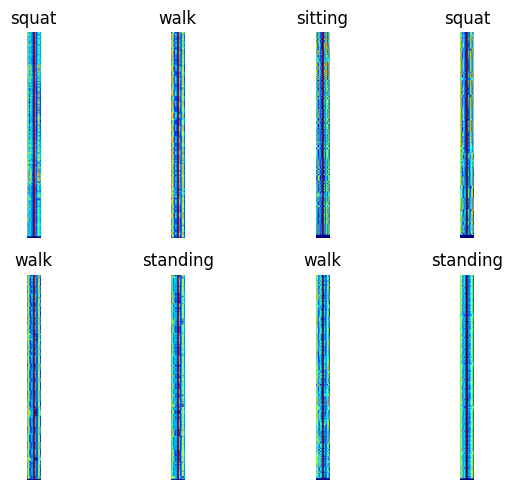

In [75]:
# Visualize some images 

# Get a batch of images and labels
images, labels = next(train_set)
class_names = list(train_set.class_indices.keys())

# Plot settings
cols = 4
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))

for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.grid(False)
    ax.axis('off')
    ax.imshow(images[i])
    true_label = class_names[np.argmax(labels[i])]
    ax.set_title(f"{true_label}")

plt.tight_layout()
plt.show()

In [76]:
# Build the CNN model
Classifier = Sequential()
Classifier.add(Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
#Block 1 
Classifier.add(Conv2D(32, (3, 3)))
Classifier.add(LeakyReLU(negative_slope=0.1))
Classifier.add(MaxPooling2D(pool_size=(2, 2)))
Classifier.add(Dropout(0.25))
Classifier.add(Flatten())
#Header
Classifier.add(Dense(128, activation='relu'))
Classifier.add(Dropout(0.1))
Classifier.add(Dense(len(train_set.class_indices), activation='softmax'))

The architecture will be revised. This simple one helps when it comes to testing 

In [77]:
# Compile the model
Classifier.compile(optimizer=Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])


print(f"Number of training images: {train_set.samples}")
print(f"Number of validation images: {validation_set.samples}")
print(f"Class indices: {train_set.class_indices}")
Classifier.summary()

Number of training images: 998
Number of validation images: 110
Class indices: {'sitting': 0, 'squat': 1, 'standing': 2, 'walk': 3}


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 998, 62, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 998, 62, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 499, 31, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 499, 31, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 495008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    63,361,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,362,564 (241.71 MB)

 Trainable params: 63,362,564 (241.71 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
# Train the model
history = Classifier.fit(
   train_set,
   epochs=20,
   validation_data=validation_set
)
Classifier.save('motion_classifier_model.keras')
print("Model saved as 'motion_classifier_model.keras'.")

c:\Users\Agent47\Desktop\Wi-fi Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3207 - loss: 5.8985 - val_accuracy: 0.6455 - val_loss: 0.9848
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5977 - loss: 0.9848 - val_accuracy: 0.6909 - val_loss: 0.8259
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7214 - loss: 0.8021 - val_accuracy: 0.6545 - val_loss: 0.8274
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.7564 - loss: 0.7235 - val_accuracy: 0.7909 - val_loss: 0.6386
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8348 - loss: 0.5606 - val_accuracy: 0.8364 - val_loss: 0.5505
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8419 - loss: 0.5114 - val_accuracy: 0.8091 - val_loss: 0.5797
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8614 - loss: 0.4924 - val_accuracy: 0.8727 - val_loss: 0.4540
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8789 - loss: 0.4311 - val_accuracy: 0.8909 - val_loss:

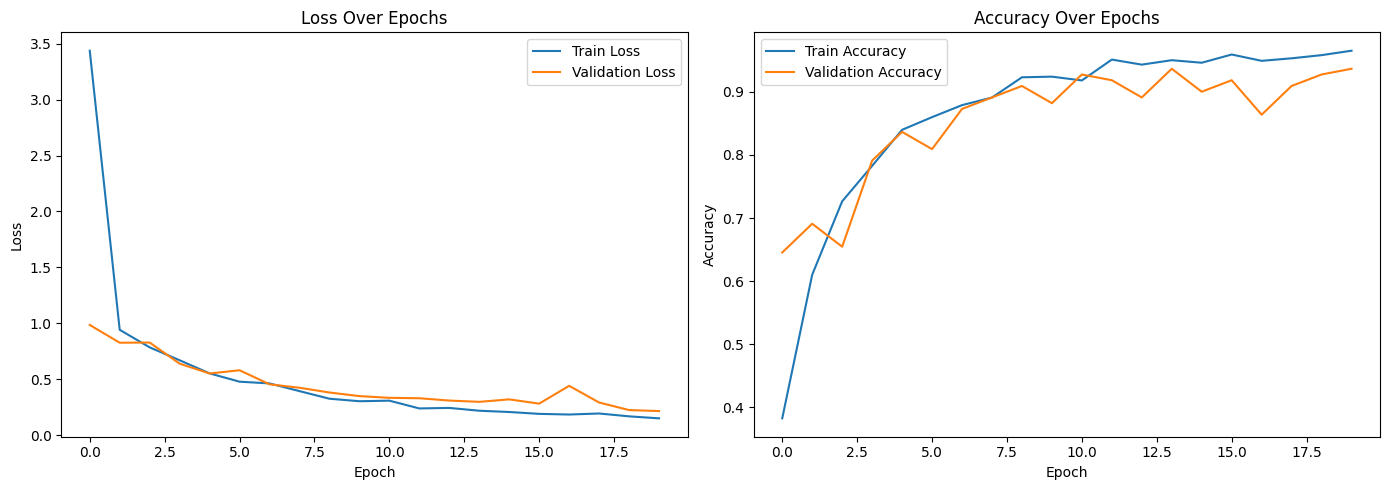

In [80]:
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Seems like the model is highly accurate and in not overfitting, however when we will have a look a the confusion matrix perspective will change....

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 219ms/step


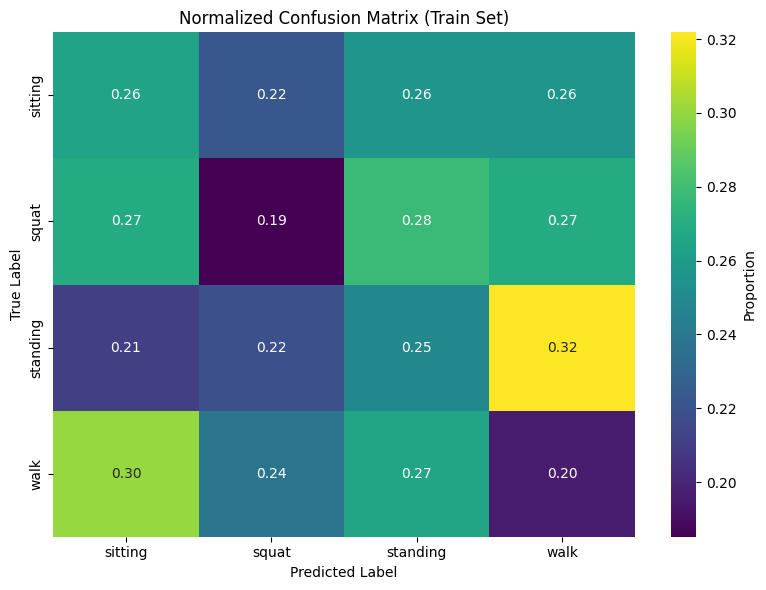

In [81]:

# Get true labels and predicted labels
y_true = train_set.classes
class_names = list(train_set.class_indices.keys())

# Predict probabilities
train_set.reset()  # Reset the generator before predicting
y_pred_probs = Classifier.predict(train_set, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percent = np.nan_to_num(cm_percent)  # Handle NaN if any class has 0 samples

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="viridis", xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Proportion'})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Train Set)")
plt.tight_layout()
plt.show()

Yes it is very uniform. This is equivalent to random guessing. The model is pretty shallow (not enough layers). I purpose to use transfer learning, features of the spectograms are hard to read both for humans and the CNN. 

We can test the model with a normal well-known model like CIFAR or MINST to see weather it will be able to learn anything. 

Note that to this file we definately need to add one-hot encoded lables - the CNNs do not undestand words.